In [1]:
import warnings
warnings.filterwarnings("ignore")
import os
path = os.getcwd() 
#This function returns the current working directory as a string.

import sys
sys.path.append("") 
#This line appends an empty string to the Python path.

from utils import * 
#This line imports all functions, classes, and variables from a module named utils.

import gc 
#The gc module provides an interface to the garbage collection facility. It is useful for managing memory in Python, 
#especially when dealing with large datasets or complex objects that might not be automatically collected.


import pandas as pd
import numpy as np
import random
import datetime

import category_encoders as ce
import lightgbm as lgb

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc, precision_recall_curve, precision_score, average_precision_score, confusion_matrix, recall_score, f1_score
from sklearn.preprocessing import OneHotEncoder, RobustScaler, StandardScaler, LabelEncoder

from hyperopt import fmin, tpe, hp, anneal, Trials

import bisect
import shap

import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.float_format', lambda x: '%.3f' % x) 
#This command sets the display format for floating-point numbers to three decimal places. This makes DataFrame outputs more readable when printed.


%load_ext autoreload
%autoreload 2 
#This command enables automatic reloading of all modules (except those that are excluded) before executing a new line. 
#This is useful in interactive environments like Jupyter Notebooks because it ensures that you always work with the latest version of your code without having to restart the kernel.

# Description of Columns
| Columns            | Description                                           |
|--------------------|-------------------------------------------------------|
| User_id            | User Identifier                                       |
| employment_type    | Employment Type (Salaried, Self-Employed)             |
| tier_of_employment | Tier of Employment (According to company performance) |
| industry           | Industry of Employer                                  |
| role               | Role of User in company                               |
| work_experience    | Total Work Experience                                 |
| total_income       | Total Income of customer                              |
| gender             | Gender of Customer                                    |
| married            | Single / Married / Divorced / Widowed etc.            |
| dependents         | No. of dependents on user                             |
| home_type          | Rented / Owned etc.                                   |
| pincode            | Middle 3 digit of Pincode                             |
| has_social_profile | Has FB/Twitter or any other social profile            |
| is_verified        | Is Social Profile Verified                            |
| delinq_2yrs        | Number of loan delinquencies in last 2 years          |
| total_payement     | Total Payment made towards loan in last 2 years       |
| received_principal | Total Principal paid towards loan in last 2 years     |
| interest_received  | Total Interest Received towards loan in last 2 years  |
| number_of_loans    | Number of Loans in last 2 years                       |
| emi_1_dpd          | DPD in repayment of 1st EMI (0, 30+, 60+, 90+)        |
| emi_2_dpd          | DPD in repayment of 2nd EMI (0, 30+, 60+, 90+)        |
| emi_3_dpd          | DPD in repayment of 3rd EMI (0, 30+, 60+, 90+)        |
| emi_4_dpd          | DPD in repayment of 4th EMI (0, 30+, 60+, 90+)        |
| emi_5_dpd          | DPD in repayment of 5th EMI (0, 30+, 60+, 90+)        |
| emi_6_dpd          | DPD in repayment of 6th EMI (0, 30+, 60+, 90+)        |
| max_dpd            | Maximum DPD (0, 30+, 60+, 90+) attained               |
| yearmo             | Year and month of loan application (YYYYMM format)    |

EMI = (Equated Monthly Instalment) = a fixed payment amount made by a borrower to a lender on a specified date each month (includes both the principal loan amount and the interest accrued over the loan tenure).
## Action Items
- Drop Industry and Role since it's garbage
- According to yearmo, split data in Train, Validation, Hold Out
- DPD Roll Rate Analysis and Window Roll Rate Analysis for defining label (default = dpd X in first Y months, Define X & Y)

In [2]:
#Defining Parameters
data_path = 'credit_risk_data.csv'# Path of data
#Non feature Columns (not to be used as features in model)
id_cols = ['User_id','emi_1_dpd', 'emi_2_dpd', 'emi_3_dpd', 'emi_4_dpd', 'emi_5_dpd', 'emi_6_dpd', 'max_dpd', 'yearmo']
drop_columns = ['industry', 'role', 'pincode']

In [3]:
# Read Data and drop Non usable Columns
df = process_data(data_path, drop_columns)
print(df.drop(columns = id_cols).shape)
df.head(5)

(143727, 15)


,User_id,employment_type,tier_of_employment,work_experience,total_income,gender,married,dependents,home_type,has_social_profile,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,7013527,Salaried,B,1-2,125000.000,Female,Yes,4,rent,No,...,852.690,0,0,90,90,90,90,90,90,202203
1,7014291,Self - Employeed,D,10+,61000.000,Female,No,1,mortgage,NaN,...,4912.530,0,0,0,0,0,0,0,0,202203
2,7014327,NaN,NaN,5-10,100000.000,Other,NaN,3,own,No,...,3310.680,0,90,90,90,90,90,90,90,202205
3,7014304,NaN,NaN,2-3,30000.000,Male,NaN,1,rent,Yes,...,1459.760,0,0,0,0,0,0,0,0,202203
4,7031995,NaN,NaN,10+,65000.000,Male,NaN,3,rent,No,...,1793.000,0,0,0,0,0,0,0,0,202203


In [4]:
# Numeric, Categorical Features, Feature wise null counts and Zero Variance Features
understand_data(df, id_cols)

Numeric Columns : ['total_income', 'dependents', 'delinq_2yrs', 'total_payement', 'received_principal', 'interest_received', 'number_of_loans']

Categorical Columns : ['employment_type', 'tier_of_employment', 'work_experience', 'gender', 'married', 'home_type', 'has_social_profile', 'is_verified']

Null Counts
employment_type       84642
tier_of_employment    84642
work_experience           4
total_income              0
gender                    0
married               48143
dependents                0
home_type                 0
has_social_profile    47856
is_verified           35803
delinq_2yrs               0
total_payement            0
received_principal        0
interest_received         0
number_of_loans           0
dtype: int64

Zero Variance Columns: Index([], dtype='object')


In [5]:
# Since Data is on timeline
df.yearmo.value_counts()

yearmo
202203    28750
202201    28750
202202    28750
202204    28750
202205    28727
Name: count, dtype: int64

In [6]:
df['married'].fillna('No',inplace=True)
df['employment_type'].fillna('Self - Employeed',inplace=True)
df['tier_of_employment'].fillna('A',inplace=True)
df['work_experience'].fillna(0,inplace=True)
df['has_social_profile'].fillna('No',inplace=True)
df['is_verified'].fillna('Not Verified',inplace=True)
df.replace('Source Verified', 'Verified', inplace=True)

In [7]:
df['home_type'].unique()

array(['rent', 'mortgage', 'own', 'none', 'other'], dtype=object)

In [8]:
df.loc[(df['tier_of_employment'] == 'E') | (df['tier_of_employment'] == 'G') | (df['tier_of_employment'] == 'F'), ['tier_of_employment']] = 4
df.loc[(df['tier_of_employment'] == 'A'), ['tier_of_employment']] = 0
df.loc[(df['tier_of_employment'] == 'B'), ['tier_of_employment']] = 1
df.loc[(df['tier_of_employment'] == 'C'), ['tier_of_employment']] = 2
df.loc[(df['tier_of_employment'] == 'D'), ['tier_of_employment']] = 3

In [9]:
df.loc[(df['work_experience'] == '1-2') | (df['work_experience'] == '2-3') | (df['work_experience'] == '3-5'), ['work_experience']] = 1
df.loc[(df['work_experience'] == '0') | (df['work_experience'] == '<1'), ['work_experience']] = 0
df.loc[(df['work_experience'] == '10+') | (df['work_experience'] == '5-10'), ['work_experience']] = 2

In [292]:
df

,User_id,employment_type,tier_of_employment,work_experience,total_income,gender,married,dependents,home_type,has_social_profile,...,interest_received,number_of_loans,emi_1_dpd,emi_2_dpd,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo
0,7013527,Salaried,1,1,125000.000,Female,Yes,4,rent,No,...,852.690,0,0,90,90,90,90,90,90,202203
1,7014291,Self - Employeed,3,2,61000.000,Female,No,1,mortgage,No,...,4912.530,0,0,0,0,0,0,0,0,202203
2,7014327,Self - Employeed,0,2,100000.000,Other,No,3,own,No,...,3310.680,0,90,90,90,90,90,90,90,202205
3,7014304,Self - Employeed,0,1,30000.000,Male,No,1,rent,Yes,...,1459.760,0,0,0,0,0,0,0,0,202203
4,7031995,Self - Employeed,0,2,65000.000,Male,No,3,rent,No,...,1793.000,0,0,0,0,0,0,0,0,202203
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
143722,55993166,Self - Employeed,0,0,100000.000,Female,No,2,mortgage,No,...,5648.570,0,0,0,0,30,0,0,30,202205
143723,56263229,Self - Employeed,0,0,27000.000,Male,Yes,3,rent,No,...,257.530,0,0,0,0,0,0,0,0,202203
143724,55992716,Self - Employeed,0,0,53000.000,Female,Yes,2,rent,No,...,3651.310,0,0,0,0,0,0,0,0,202204
143725,56363313,Self - Employeed,0,0,75400.000,Other,No,0,mortgage,No,...,793.820,0,0,0,0,0,0,30,30,202202


Split data on timeline to make sure model developed is able to predict well on Out of time data
<br>**Train** - Yearmo 202201 to 202203
<br>**Validation** - Yearmo 202204
<br>**Hold Out** - Yearmo 202205 (Out of time data)

In [293]:
train, val, hold_out = data_split(df)

# Define Label (Roll Rate Analysis)
## DPD Roll Rate

In [294]:
# % of customer achieved X dpd (Since everyone starts at 0 dpd so 100% will be at 0 dpd)
dpd_roll_rate(train)

,dpd,user_count,user_percent
0,0,86250,100.0 %
1,30,22073,25.59 %
2,60,8099,9.39 %
3,90,7926,9.19 %


As we can see
<br>- ~25.6% customer paid back after crossing dpd30
<br>- Most of the people who crossed dpd60 are also crossing dpd 90
<br>**Conclusion** - *DPD60 should be right choice as Recovery rate is low post that*

## window Roll Rate

In [295]:
# For DPD 60 analyzing % of customer attain dpd60 on various lifecycle of EMI
window_roll_rate(train, 60)

,first_default_emi,users_count,% of Users
0,1,6546,80.82 %
1,2,1084,13.38 %
2,3,421,5.2 %
3,4,22,0.27 %
4,5,18,0.22 %
5,6,8,0.1 %


As we can see
<br>- 80.8% of Defaulters dafault in 1st EMI and 5.2% default in 3rd EMI, Post 3rd EMI rate is low, so we can conclude people Most of the Defaulter default in 1st 3 EMIs
<br>**Conclusion** - We can use DPD60 in first 3 months as our label

## Label Creation

In [296]:
# We will call Class 1 a defaulter
train = create_label(train, dpd = 60, months = 3)
val = create_label(val, dpd = 60, months = 3)
hold_out = create_label(hold_out, dpd = 60, months = 3)

label columns added to dataframe
label columns added to dataframe
label columns added to dataframe


### Label Distribution

In [297]:
label_distribution([train, val, hold_out], ['Training', 'Validation', 'Hold Out'], 'label')


label distribution of Training
   label  user_count  % users
0      0       78199   90.666
1      1        8051    9.334

label distribution of Validation
   label  user_count  % users
0      0       25941   90.230
1      1        2809    9.770

label distribution of Hold Out
   label  user_count  % users
0      0       26118   90.918
1      1        2609    9.082


- Labels are imbalanced towards class 0
- Same level of Imbalance occure across Train, Validation, Hold Out

# Create Features

In [298]:
# We are adding few features
## - % Amount Paid as interest in past Loan Repayment
## - % of Loans defaulted in last 2 years
train = derived_features(train)
val = derived_features(val)
hold_out = derived_features(hold_out)

# EDA
## Univariate

In [299]:
id_cols.append('label')
e = eda(train, id_cols)

In [300]:
# Univariate Distribution of Numeric Features
e.numeric_summary()

,total_income,dependents,delinq_2yrs,total_payement,received_principal,interest_received,number_of_loans,interest_received_ratio,total_payement_per_loan,delinq_2yrs_ratio
count,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000,86250.000
mean,72337.323,2.001,0.280,10806.131,8371.521,2354.687,0.006,0.238,39.107,0.001
std,58969.955,1.410,0.798,8603.037,7202.593,2458.578,0.098,0.146,834.130,0.043
min,4800.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,45000.000,1.000,0.000,4655.845,3091.600,841.812,0.000,0.135,0.000,0.000
50%,61174.270,2.000,0.000,8173.695,6000.000,1630.580,0.000,0.200,0.000,0.000
75%,86000.000,3.000,0.000,14136.720,11550.000,2902.170,0.000,0.310,0.000,0.000
max,7141778.000,4.000,22.000,57777.580,35000.010,23450.380,5.000,0.845,41875.060,5.000


In [301]:
# Categorical Features Summary
e.categorical_summary()

,employment_type,tier_of_employment,work_experience,gender,married,home_type,has_social_profile,is_verified
count,86250,86250,86250,86250,86250,86250,86250,86250
unique,2,5,3,3,2,5,2,2
top,Self - Employeed,0,0,Other,No,mortgage,No,Verified
freq,57510,57619,73378,28903,57746,42088,57628,43343


## Bivariate

### Correlation

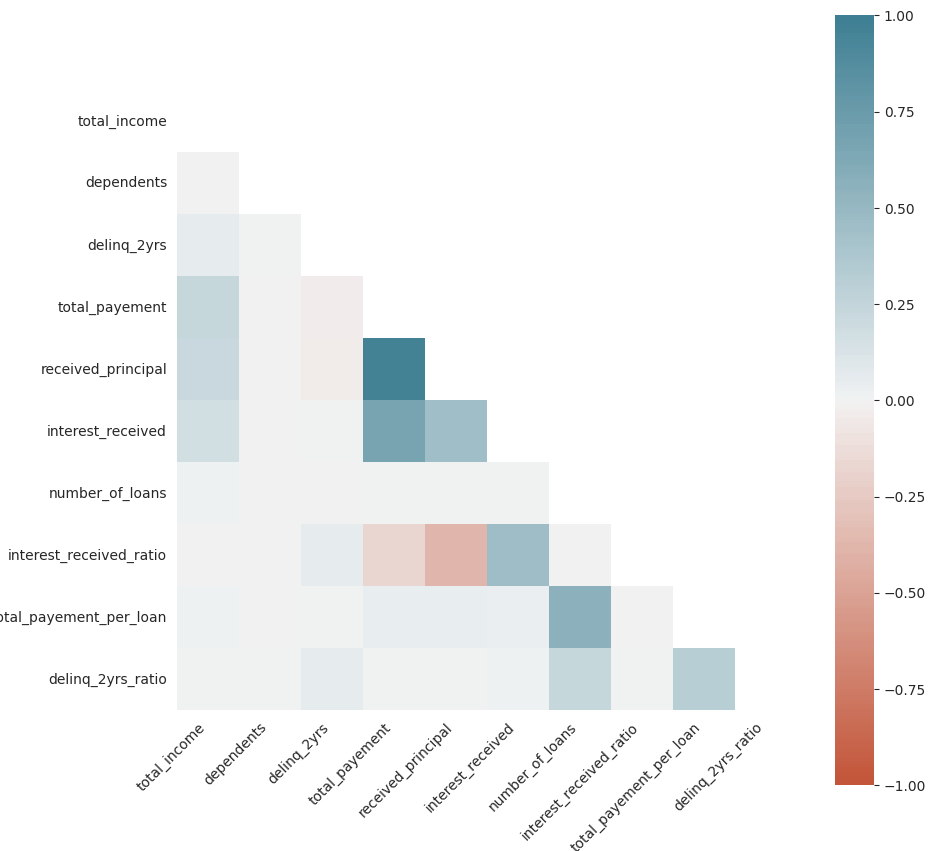

In [302]:
e.correlation_plot()

Some Observations
<br> - Total payment and Received Principal are highly correlated (0.96)
<br> - Interest Received and Total payment are mildely correlated (0.67)

### Box Plot vs Label

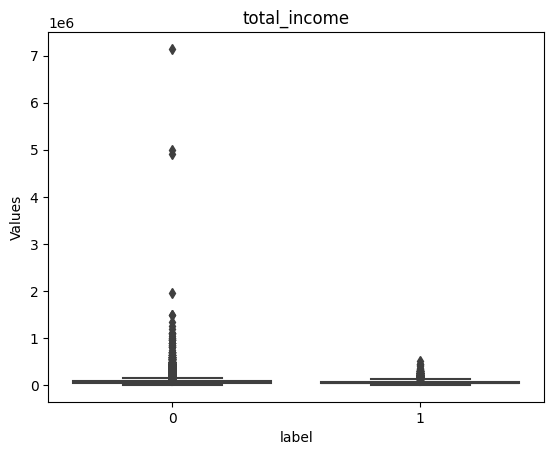

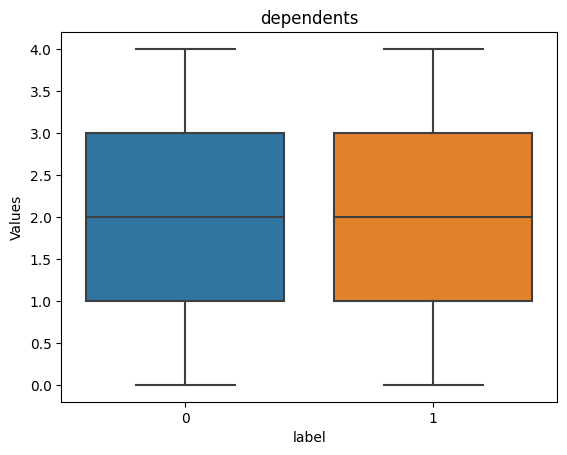

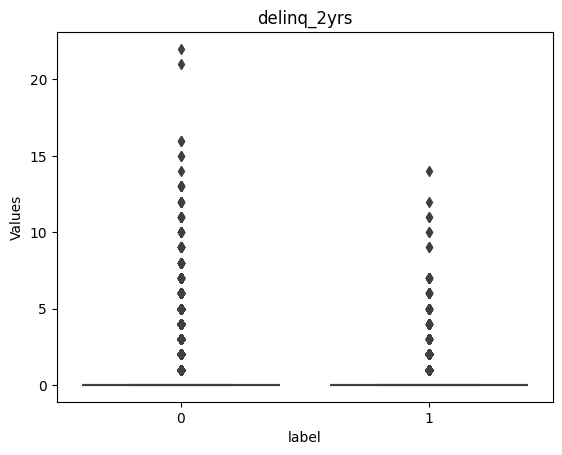

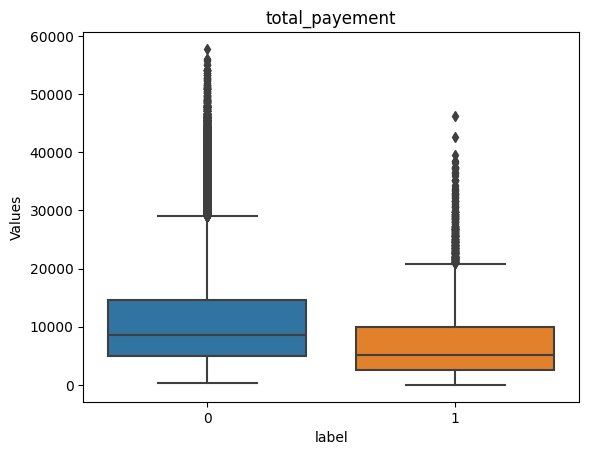

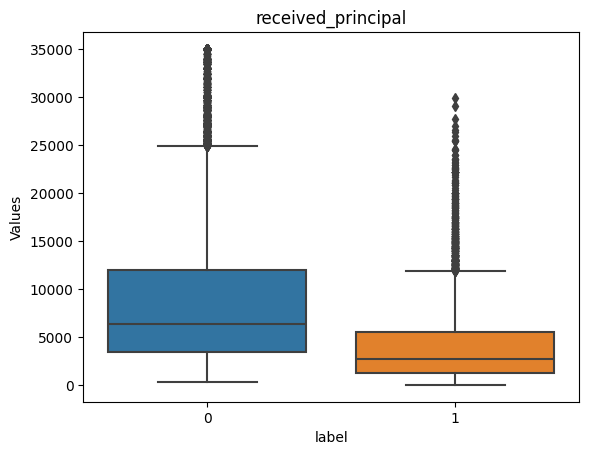

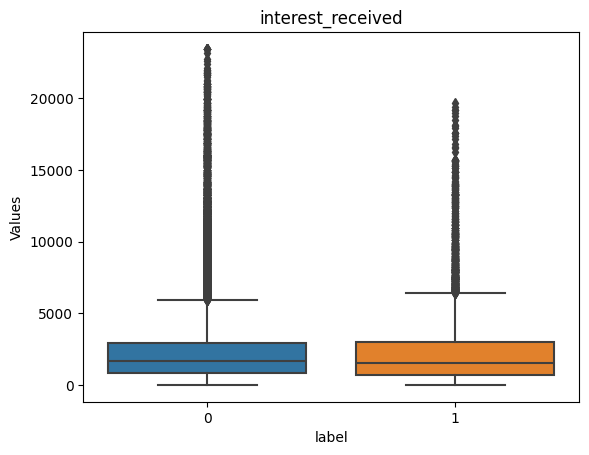

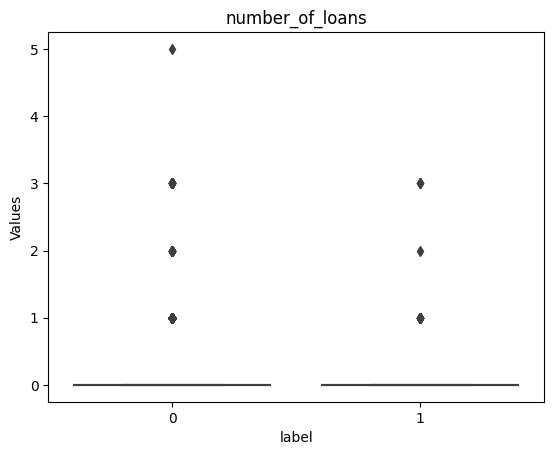

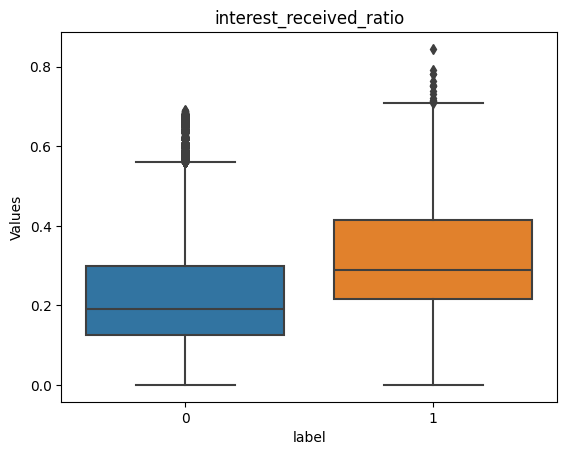

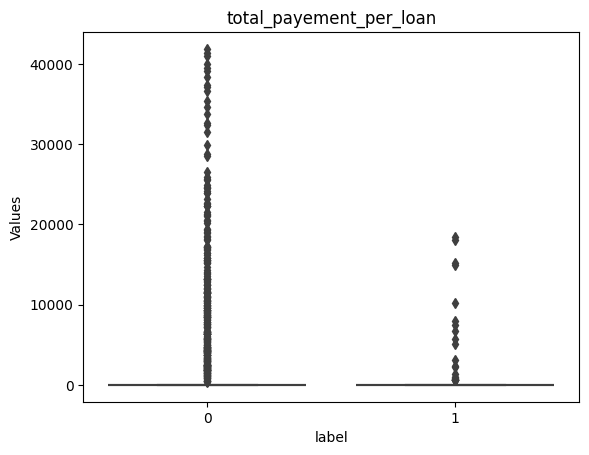

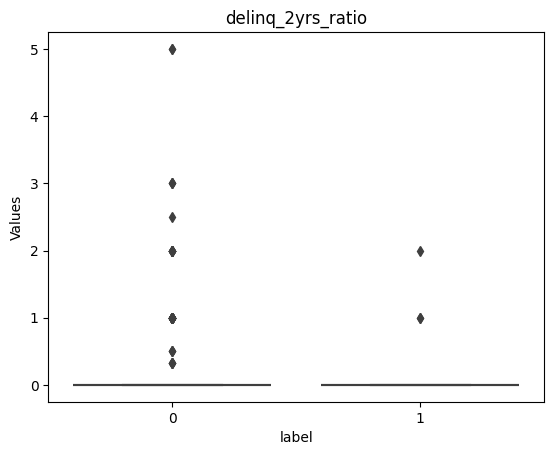

In [303]:
# Box Plot Seggregated by Defaulter and Non Defaulters
e.box_plot(group = ['label'])

Observation
- Distribution of Total Payment, Received Principal, Interest Received Ratio is different for Defaulters and Non-Defaulters
<br> 
<br>these can be some important features

# Categorical Features Transformation

Please Refer
<br> [Paper](https://arxiv.org/pdf/1904.13001.pdf)
<br> [Library](https://contrib.scikit-learn.org/category_encoders/)
<br> to understand Target Encoding better

In [304]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 86250 entries, 0 to 86249
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   User_id                  86250 non-null  int64  
 1   employment_type          86250 non-null  object 
 2   tier_of_employment       86250 non-null  object 
 3   work_experience          86250 non-null  object 
 4   total_income             86250 non-null  float64
 5   gender                   86250 non-null  object 
 6   married                  86250 non-null  object 
 7   dependents               86250 non-null  int64  
 8   home_type                86250 non-null  object 
 9   has_social_profile       86250 non-null  object 
 10  is_verified              86250 non-null  object 
 11  delinq_2yrs              86250 non-null  int64  
 12  total_payement           86250 non-null  float64
 13  received_principal       86250 non-null  float64
 14  interest_received     

In [305]:
cat_cols = train.drop(columns = id_cols).select_dtypes(include=['category', 'object']).columns
params = {"verbose":0,
          "cols":None,
          "drop_invariant":False,
          "return_df":True,
          "handle_missing":'value',
          "handle_unknown":'value',
          "min_samples_leaf":5000,
          "smoothing":1}
target_encoder = categorical_encoding(params)
target_encoder.fit(train, cat_cols, 'label')

In [306]:
train

,User_id,employment_type,tier_of_employment,work_experience,total_income,gender,married,dependents,home_type,has_social_profile,...,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo,label,interest_received_ratio,total_payement_per_loan,delinq_2yrs_ratio
0,7013527,Salaried,1,1,125000.000,Female,Yes,4,rent,No,...,90,90,90,90,90,202203,1,0.467,0.000,0.000
1,7014291,Self - Employeed,3,2,61000.000,Female,No,1,mortgage,No,...,0,0,0,0,0,202203,0,0.214,0.000,0.000
2,7014304,Self - Employeed,0,1,30000.000,Male,No,1,rent,Yes,...,0,0,0,0,0,202203,0,0.219,0.000,0.000
3,7031995,Self - Employeed,0,2,65000.000,Male,No,3,rent,No,...,0,0,0,0,0,202203,0,0.152,0.000,0.000
4,7033985,Self - Employeed,0,2,90000.000,Male,No,4,mortgage,No,...,0,0,0,0,0,202201,0,0.131,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86245,55883413,Self - Employeed,0,0,70000.000,Male,No,3,mortgage,Yes,...,0,0,0,0,0,202202,0,0.113,0.000,0.000
86246,55973430,Self - Employeed,0,0,30000.000,Other,Yes,1,mortgage,No,...,0,0,0,0,0,202201,0,0.289,0.000,0.000
86247,56263229,Self - Employeed,0,0,27000.000,Male,Yes,3,rent,No,...,0,0,0,0,0,202203,0,0.307,0.000,0.000
86248,56363313,Self - Employeed,0,0,75400.000,Other,No,0,mortgage,No,...,0,0,0,30,30,202202,0,0.195,0.000,0.000


In [307]:
#train = target_encoder.transform(train)
#val = target_encoder.transform(val)
#hold_out = target_encoder.transform(hold_out)

cols = ('employment_type', 'tier_of_employment', 'work_experience', 'gender', 'married', 'home_type', 'has_social_profile', 'is_verified')
# process columns, apply LabelEncoder to categorical features
for c in cols:
    lbl = LabelEncoder() 
    lbl.fit(list(train[c].values)) 
    train[c] = lbl.transform(list(train[c].values))
    lbl.fit(list(val[c].values)) 
    val[c] = lbl.transform(list(val[c].values))
    lbl.fit(list(hold_out[c].values)) 
    hold_out[c] = lbl.transform(list(hold_out[c].values))

In [308]:
train

,User_id,employment_type,tier_of_employment,work_experience,total_income,gender,married,dependents,home_type,has_social_profile,...,emi_3_dpd,emi_4_dpd,emi_5_dpd,emi_6_dpd,max_dpd,yearmo,label,interest_received_ratio,total_payement_per_loan,delinq_2yrs_ratio
0,7013527,0,1,1,125000.000,0,1,4,4,0,...,90,90,90,90,90,202203,1,0.467,0.000,0.000
1,7014291,1,3,2,61000.000,0,0,1,0,0,...,0,0,0,0,0,202203,0,0.214,0.000,0.000
2,7014304,1,0,1,30000.000,1,0,1,4,1,...,0,0,0,0,0,202203,0,0.219,0.000,0.000
3,7031995,1,0,2,65000.000,1,0,3,4,0,...,0,0,0,0,0,202203,0,0.152,0.000,0.000
4,7033985,1,0,2,90000.000,1,0,4,0,0,...,0,0,0,0,0,202201,0,0.131,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86245,55883413,1,0,0,70000.000,1,0,3,0,1,...,0,0,0,0,0,202202,0,0.113,0.000,0.000
86246,55973430,1,0,0,30000.000,2,1,1,0,0,...,0,0,0,0,0,202201,0,0.289,0.000,0.000
86247,56263229,1,0,0,27000.000,1,1,3,4,0,...,0,0,0,0,0,202203,0,0.307,0.000,0.000
86248,56363313,1,0,0,75400.000,2,0,0,0,0,...,0,0,0,30,30,202202,0,0.195,0.000,0.000


In [364]:
val['label'].value_counts()

label
0    25941
1     2809
Name: count, dtype: int64

# Feature Selection
<br> There can be many methods to do feature selection like Mrmr, KS, Information Gain etc., Random Forest and Deep Decision Tree can also be used as Feature Selection</br>
<br> 
**Random Forest** - Since Random Forest subset features too, so every feature gets chance to split tree
<br> 
**Decision Tree** - Decision Tree Uses Greedy Algorithm to split Tree so choose between 2 correlated features which one is best
<br>
<br>Drop features which are of 0 importance in Random Forest and Decision Tree

## Random Forest

In [309]:
rf_params = {"n_estimators":250, 'criterion':'entropy','verbose':False, 'n_jobs':25}
rf_zero_imp = random_forest_zero_importance(train, id_cols, 'label', rf_params)

## Decision Tree

In [310]:
dt_params = {}
dt_zero_imp = decision_tree_zero_importance(train, id_cols, 'label', dt_params)

## Zero Importance Columns

In [311]:
drop_cols = list(set(rf_zero_imp) & set(dt_zero_imp))
print(drop_cols)

[]


# Model Development
## Hyperparameter Tuning

We will try to search hyperparameter using Hyperopt, Following are relevant links to understand Hyperopt better
- [Paper](https://conference.scipy.org/proceedings/scipy2013/pdfs/bergstra_hyperopt.pdf)
- [Library](http://hyperopt.github.io/hyperopt/)

Hyperopt tries to minimize of score (to be defined by user) by smartly iterating though various combination of hypeparameters in given space
<br>
Score = (Train ROC AUC - Val ROC AUC + 1)/(Val ROC AUC)
<br>
<br>
**Intution**
- Train ROC AUC - Val ROC AUC will reduce overfitting
<br> 
- 1/(Val ROC AUC) will increase ROC AUC for Validation Set
</br>
After Every Iteration we are appending results to the results of existing runs and saving to hyperopt_results.csv, so in case we halt the run in between, we will not loose results

<br></br>
**Setting**
<br>- Loss Function = LogLoss
<br>- Implementation = Lightgbm Implementation of Boosting Algorithm 
<br>- Primary Evalution Metric - ROC AUC
<br>- Hypeparameter Selection - Hyperopt

In [316]:
result_ho = pd.DataFrame() #An empty DataFrame to store hyperparameter tuning results.
i = 0 #A counter to keep track of the number of iterations.

## Defining Objective Function
## will return the score to optimise
def objective(space):
    
    global i
    global result_ho
    
    #Creating Lightgbm DataFrame
    lgb_train = lgb.Dataset(train.drop(columns = id_cols+drop_cols), label = train.label)
    lgb_val = lgb.Dataset(val.drop(columns = id_cols+drop_cols), label = val.label)

    #Parameters of model
    params = {
        'num_leaves': int(space['num_leaves']),
        'max_depth': int(space['max_depth']),
        'learning_rate': space['learning_rate'],
        'objective': 'binary',
        'metric': 'auc',
        "boosting": "gbdt",
        'feature_fraction' : space['feature_fraction'],
        'max_bin' : int(space['max_bin']),
        'min_data_in_leaf': int(space['min_data_in_leaf']),
        "min_data_in_bin": int(space['min_data_in_bin']),
        "bagging_freq": 20,
        "random_seed": 2019,
        "lambda_l1": space['lambda_l1'], # L1 regularization
        "lambda_l2": space['lambda_l2'], # L2 regularization
        'pos_bagging_fraction' : space['pos_bagging_fraction'],
        'neg_bagging_fraction' : space['neg_bagging_fraction'],
        'verbose': -1
    }
    evals_result = {}

    clf = lgb.train(params, lgb_train, 20000, valid_sets=lgb_val,
                valid_names='val',
                callbacks=[lgb.early_stopping(stopping_rounds=25), lgb.record_evaluation(eval_result=evals_result)], #Early stopping is applied to prevent overfitting.
                )
    gc.collect()
    
    result = pd.DataFrame([clf.params])
    
    #Predictions are made on the training, validation, and hold-out datasets.
    ## Calculating AUC
    pred_train = clf.predict(train[clf.feature_name()])
    pred_val = clf.predict(val[clf.feature_name()])
    pred_hold_out = clf.predict(hold_out[clf.feature_name()])

    gc.collect()
    train_auc = roc_auc_score(train.label, pred_train)#, num_iteration=clf.best_iteration)
    val_auc = roc_auc_score(val.label, pred_val)#, num_iteration=clf.best_iteration)
    hold_out_auc = roc_auc_score(hold_out.label, pred_hold_out)#, num_iteration=clf.best_iteration)
    gc.collect()

    #A custom score is calculated based on the difference between training and validation AUCs, and validation AUC.
    score = (abs(train_auc - val_auc) + 1)/((1+val_auc)*(1+val_auc))
    
    result["train_auc"] = train_auc
    result["val_auc"] = val_auc
    result["hold_out_auc"] = hold_out_auc
    result["train_test_diff"] = train_auc - val_auc
    result["n_estimators"] = clf.best_iteration
    result["score"] = score
    

    result_ho = pd.concat([result_ho, result], ignore_index=True)
    result_ho.to_csv('hyperopt_results.csv', index=False)
    #The results are stored in result_ho DataFrame and saved to a CSV file.

    i = i+1
    
    return (score)

In [317]:
# Calculate scale_pos_weight for class imbalance handling
scale_pos_weight = train['label'].value_counts()[0] / train['label'].value_counts()[1]
#the ratio of the number of negative samples to the number of positive samples.

In [318]:
## Hyperparameter space
## Space is selection of data point from the given distribution
## Distribution is defined for every hyperparameter seperately
space = {
    'num_leaves': hp.quniform('num_leaves', 2, 24, 1), # Uniform integer between 2 and 24
    'max_depth': hp.quniform('max_depth', 2, 12, 1), # Uniform integer between 2 and 12
    'learning_rate': hp.uniform('learning_rate', 0.005, 0.015), # Values between 0.005 to 0.015
    'feature_fraction' : hp.uniform('feature_fraction', 0.1, 1), # Values between 0.1 to 1
    'max_bin' : hp.quniform('max_bin', 10, 100, 10),
    'min_data_in_leaf' : hp.quniform('min_data_in_leaf', 25, 1000, 25),
    'lambda_l1' : hp.uniform('lambda_l1', 0, 5.0), # L1 regularization
    'lambda_l2' : hp.uniform('lambda_l2', 0, 5.0), # L2 regularization
    'min_data_in_bin' : hp.quniform('min_data_in_bin', 5, 100, 5),
    'pos_bagging_fraction' : hp.uniform('pos_bagging_fraction', 0.1, 1),
    'neg_bagging_fraction' : hp.uniform('neg_bagging_fraction', 0.1, 1),
    'scale_pos_weight': hp.choice('scale_pos_weight', [scale_pos_weight])  # Fixing the scale_pos_weight
    }

In [319]:
#Use fmin from Hyperopt to find the best set of hyperparameters by minimizing the negative precision score.

best=fmin(fn = objective, # function to optimize
          space = space, # space from which hyperparameter to be choosen
          algo = tpe.suggest, # optimization algorithm, hyperopt will select its parameters automatically. The algorithm to use for optimization (Tree-structured Parzen Estimator).
          max_evals = 25, #The maximum number of evaluations.
          rstate = np.random.default_rng(7) #Random state for reproducibility
         )

Training until validation scores don't improve for 25 rounds
Early stopping, best iteration is:                    
[55]	val's auc: 0.820466
Training until validation scores don't improve for 25 rounds                   
Early stopping, best iteration is:                                             
[2858]	val's auc: 0.882158
Training until validation scores don't improve for 25 rounds                    
Early stopping, best iteration is:                                              
[3319]	val's auc: 0.936567
Training until validation scores don't improve for 25 rounds                    
Early stopping, best iteration is:                                              
[3542]	val's auc: 0.942472
Training until validation scores don't improve for 25 rounds                    
Early stopping, best iteration is:                                              
[67]	val's auc: 0.819858
Training until validation scores don't improve for 25 rounds                    
Early stopping, best itera

## Model Selection

From Hyperopt Results we will choose best parameters according to following criteria. It is not necessary we use that particular hyperparameter
- High Score
- High Validation AUC
- Low Overfitting

In [320]:
hyperopt_results = pd.read_csv('hyperopt_results.csv')

In [321]:
hyperopt_results.head(5)

,num_leaves,max_depth,learning_rate,objective,metric,boosting,feature_fraction,max_bin,min_data_in_leaf,min_data_in_bin,...,pos_bagging_fraction,neg_bagging_fraction,verbose,num_iterations,train_auc,val_auc,hold_out_auc,train_test_diff,n_estimators,score
0,18,3,0.009,binary,auc,gbdt,0.202,80,875,55,...,0.334,0.647,-1,20000,0.820,0.820,0.819,0.001,55,0.302
1,10,6,0.015,binary,auc,gbdt,0.238,10,225,65,...,0.460,0.468,-1,20000,0.886,0.882,0.881,0.003,2858,0.283
2,9,8,0.009,binary,auc,gbdt,0.789,90,550,55,...,0.376,0.866,-1,20000,0.943,0.937,0.930,0.006,3319,0.268
3,19,9,0.009,binary,auc,gbdt,0.475,70,100,60,...,0.303,0.894,-1,20000,0.960,0.942,0.937,0.017,3542,0.270
4,6,12,0.007,binary,auc,gbdt,0.908,60,500,25,...,0.138,0.792,-1,20000,0.820,0.820,0.819,0.000,67,0.302


In [322]:
hyperopt_results.sort_values(by = 'score').head(5)

,num_leaves,max_depth,learning_rate,objective,metric,boosting,feature_fraction,max_bin,min_data_in_leaf,min_data_in_bin,...,pos_bagging_fraction,neg_bagging_fraction,verbose,num_iterations,train_auc,val_auc,hold_out_auc,train_test_diff,n_estimators,score
24,16,9,0.013,binary,auc,gbdt,0.671,90,625,95,...,0.788,0.988,-1,20000,0.957,0.945,0.940,0.013,3299,0.268
22,12,8,0.013,binary,auc,gbdt,0.681,100,625,85,...,0.659,0.978,-1,20000,0.949,0.940,0.935,0.008,2859,0.268
20,13,8,0.013,binary,auc,gbdt,0.699,100,650,80,...,0.651,0.993,-1,20000,0.951,0.941,0.937,0.009,2838,0.268
21,12,8,0.013,binary,auc,gbdt,0.679,100,650,85,...,0.659,0.980,-1,20000,0.950,0.941,0.936,0.009,2940,0.268
2,9,8,0.009,binary,auc,gbdt,0.789,90,550,55,...,0.376,0.866,-1,20000,0.943,0.937,0.930,0.006,3319,0.268


In [323]:
hyperopt_results.sort_values(by = 'val_auc', ascending=False).head(5)

,num_leaves,max_depth,learning_rate,objective,metric,boosting,feature_fraction,max_bin,min_data_in_leaf,min_data_in_bin,...,pos_bagging_fraction,neg_bagging_fraction,verbose,num_iterations,train_auc,val_auc,hold_out_auc,train_test_diff,n_estimators,score
24,16,9,0.013,binary,auc,gbdt,0.671,90,625,95,...,0.788,0.988,-1,20000,0.957,0.945,0.940,0.013,3299,0.268
3,19,9,0.009,binary,auc,gbdt,0.475,70,100,60,...,0.303,0.894,-1,20000,0.960,0.942,0.937,0.017,3542,0.270
20,13,8,0.013,binary,auc,gbdt,0.699,100,650,80,...,0.651,0.993,-1,20000,0.951,0.941,0.937,0.009,2838,0.268
21,12,8,0.013,binary,auc,gbdt,0.679,100,650,85,...,0.659,0.980,-1,20000,0.950,0.941,0.936,0.009,2940,0.268
22,12,8,0.013,binary,auc,gbdt,0.681,100,625,85,...,0.659,0.978,-1,20000,0.949,0.940,0.935,0.008,2859,0.268


In [324]:
# check the minimum score and select the index as best parameter index

best_param_index = hyperopt_results.index[hyperopt_results['score'] == hyperopt_results['score'].min()].tolist()[0]
lgbm_params = dict(hyperopt_results.iloc[best_param_index,:19])

## Selected Model

Lightgbm Details
- [Paper](https://proceedings.neurips.cc/paper/2017/file/6449f44a102fde848669bdd9eb6b76fa-Paper.pdf)
- [Library](https://lightgbm.readthedocs.io/en/v3.3.2/)

In [325]:
lgb_train = lgb.Dataset(train.drop(columns = id_cols+drop_cols), label = train['label'])
lgb_val = lgb.Dataset(val.drop(columns = id_cols+drop_cols), label = val['label'])

#The final model is trained using the best hyperparameters.
evals_result = {}

clf = lgb.train(lgbm_params, 
                lgb_train, 
                20000, 
                valid_sets=lgb_val,
                valid_names='val',
                callbacks=[lgb.early_stopping(stopping_rounds=50), lgb.record_evaluation(eval_result=evals_result)],
                )

Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[3299]	val's auc: 0.9447


# Model Evalution

In [326]:
#Predictions from Model on Training, Validation and Hold Out
pred_train = clf.predict(train[clf.feature_name()])
pred_val = clf.predict(val[clf.feature_name()])
pred_hold_out = clf.predict(hold_out[clf.feature_name()])

### ROC AUC, PR AUC, KS Stats

- The ROC AUC (Receiver Operating Characteristic Area Under the Curve) score is a measure of the model's ability to distinguish between the positive and negative classes. It ranges from 0 to 1, with a higher value indicating better performance.

- The PR AUC (Precision-Recall Area Under the Curve) score for Class 1 measures the precision and recall trade-off specifically for the positive class. It ranges from 0 to 1, with a higher value indicating better performance. 

In [327]:
#Printing ROC AUC, PR AUC for Class 1 and Class 0
print("ROC AUC")
roc_auc([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])
print("")
print("Class 1 PR AUC")
pr_auc([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])
print("")
print("Class 0 PR AUC")
pr_auc([1-train.label,1-val.label,1-hold_out.label], [1-pred_train, 1-pred_val, 1-pred_hold_out])
print("")

ROC AUC
0.9573509917003435
0.9447001410174846
0.9398590546292966

Class 1 PR AUC
0.8420996845156253
0.8260899963323793
0.8047980968891865

Class 0 PR AUC
0.9946887256911244
0.9922409789002492
0.9923343487021163



**Summary of the Results**

- **ROC AUC:**
The model performs very well with high ROC AUC scores across all datasets, indicating good discriminative power between the positive and negative classes.

- **PR AUC for Class 1:**
The model shows good performance for the positive class, although slightly lower than the negative class, which is common in imbalanced datasets.

- **PR AUC for Class 0:**
The model performs exceptionally well for the negative class, indicating high precision and recall for predicting the negative class.

### ROC Curve

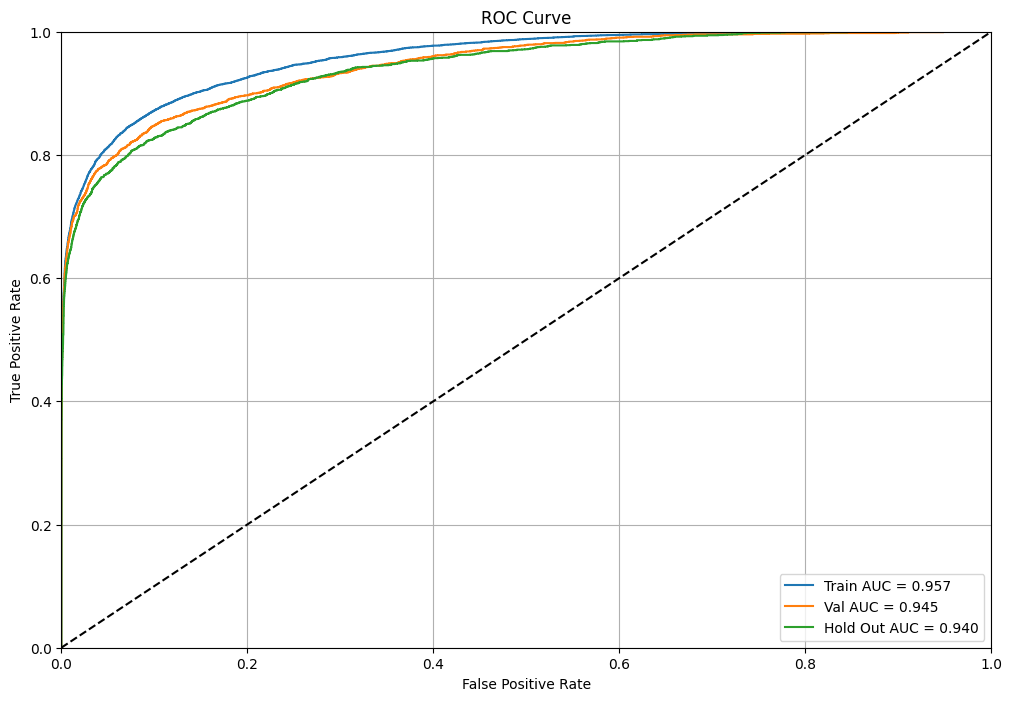

In [328]:
roc_auc_curve([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])

### PR Curve

PR Curve for Class 1


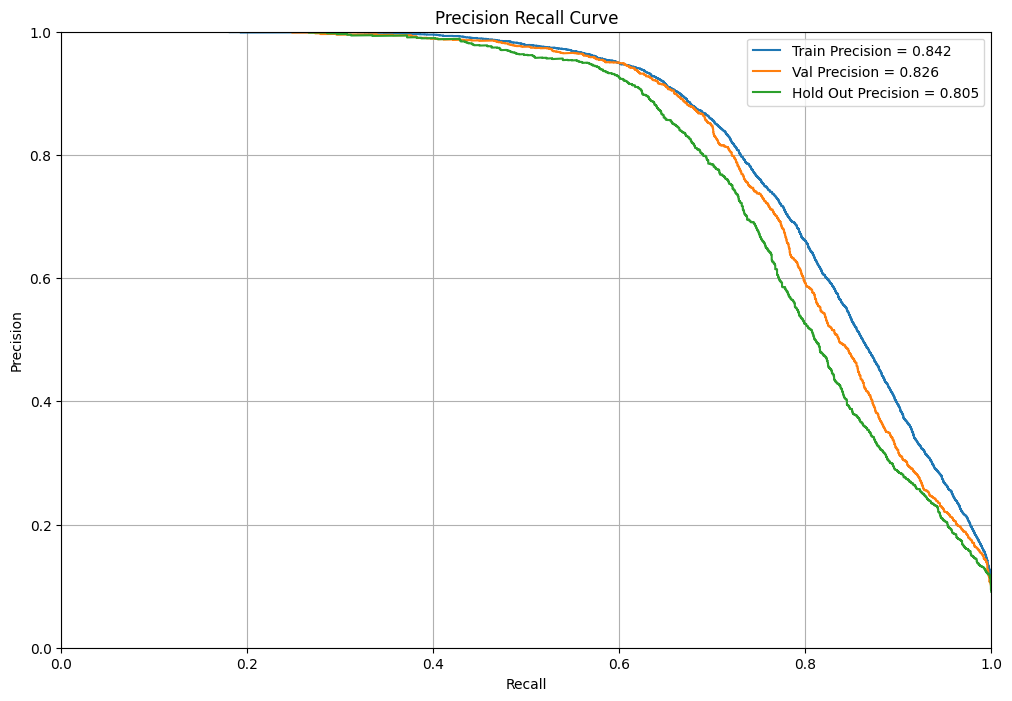

In [329]:
print("PR Curve for Class 1")
pr_auc_curve([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out])

PR Curve for Class 0


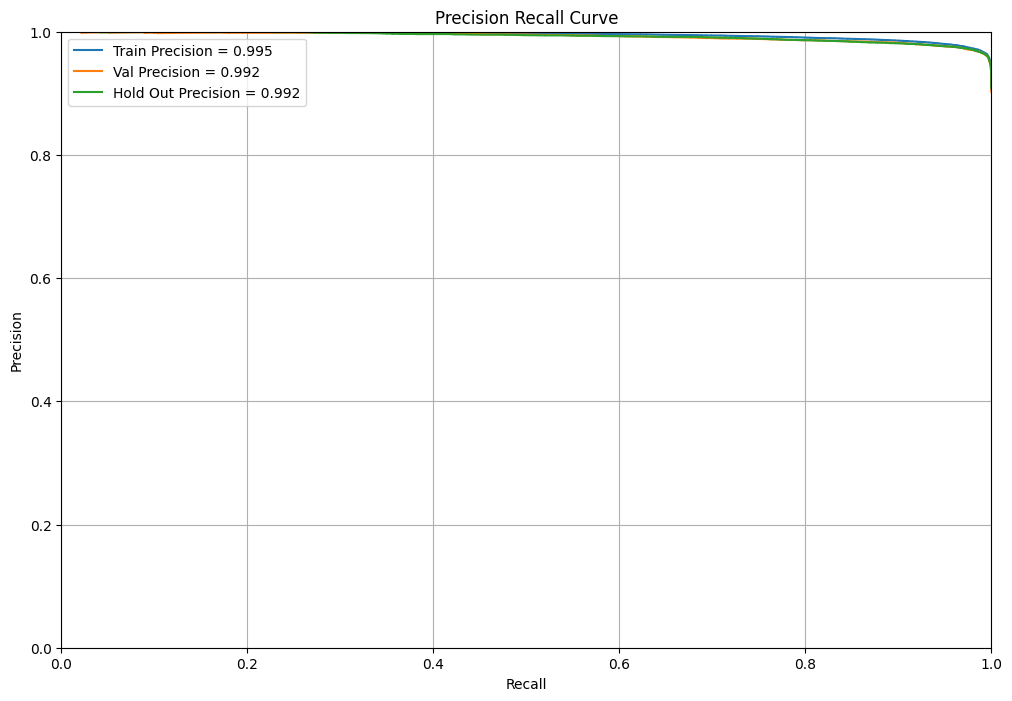

In [330]:
print("PR Curve for Class 0")
pr_auc_curve([1-train.label,1-val.label,1-hold_out.label], [1-pred_train, 1-pred_val, 1-pred_hold_out])

### Score Distribution

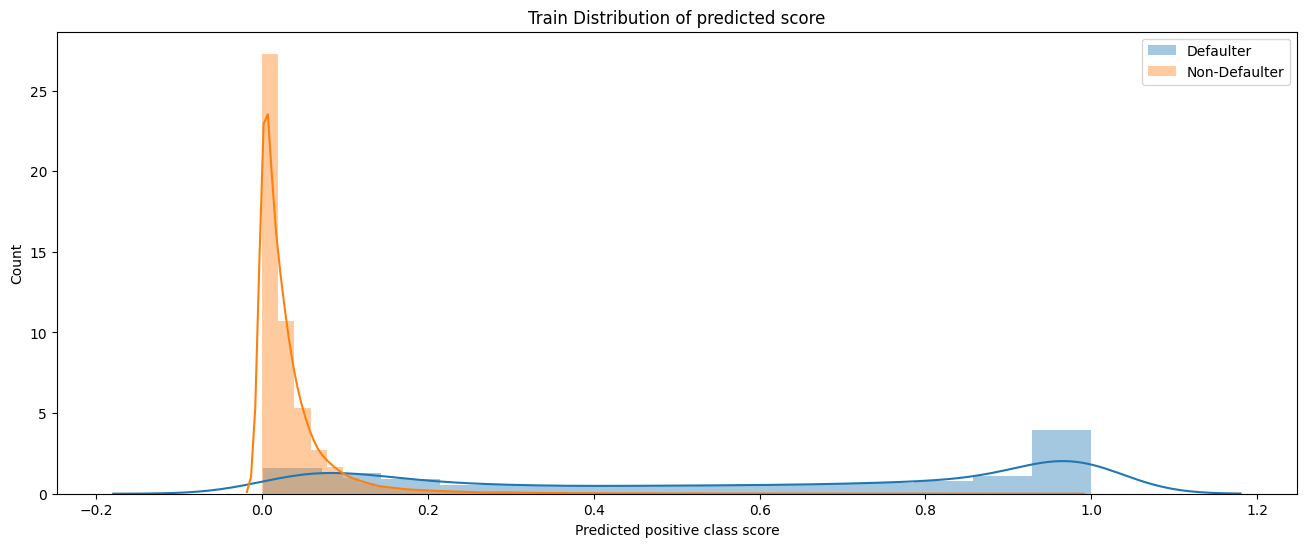

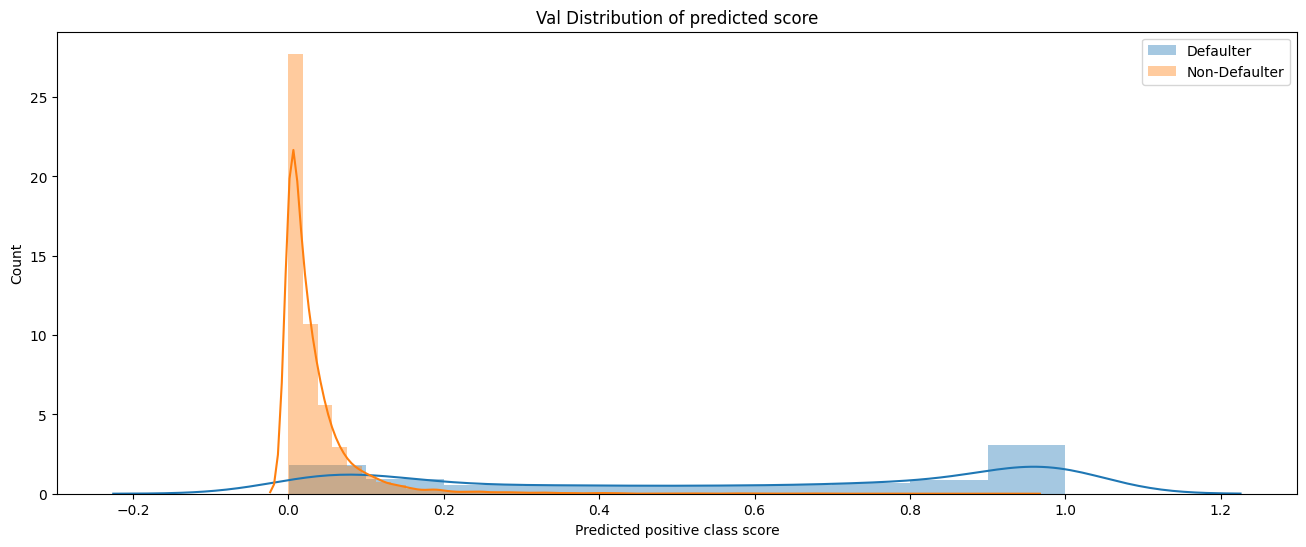

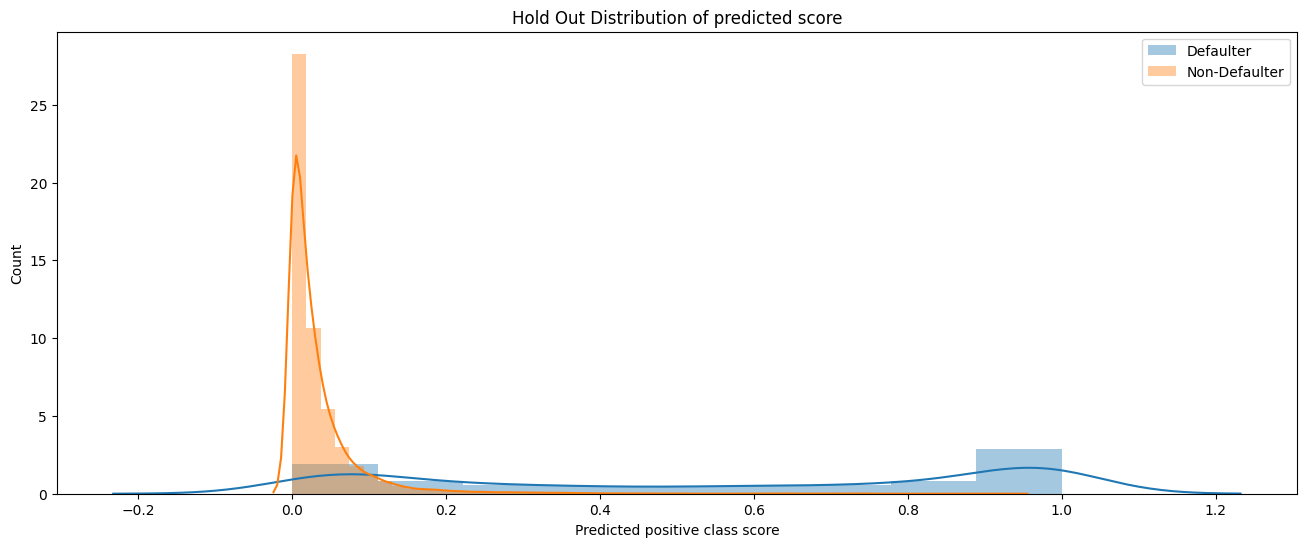

In [331]:
score_distribution([train.label,val.label,hold_out.label], [pred_train, pred_val, pred_hold_out], ["Train","Val","Hold Out"])

## Feature Importance
### Split & Gain

In [332]:
feature_importance = pd.DataFrame({"feature":clf.feature_name(),"split":clf.feature_importance('split'), "gain":clf.feature_importance('gain')}).sort_values(by = 'gain', ascending = False)
feature_importance.iloc[:10,:]

# Calculate feature importance
feature_importance = pd.DataFrame({ "feature": clf.feature_name(),
                                    "split": clf.feature_importance('split'), #This calculates the feature importance based on the number of times a feature is used to split the data across all trees in the model.
                                    "gain": clf.feature_importance('gain') #This calculates the feature importance based on the total gain (improvement in accuracy) brought by a feature to the model.
                                }).sort_values(by='gain', ascending=False)

# Display the top 10 important features
feature_importance.iloc[:10, :]

,feature,split,gain
12,received_principal,11961,383322.155
15,interest_received_ratio,9974,232715.615
11,total_payement,9846,212021.175
13,interest_received,6189,90213.846
2,work_experience,852,45926.211
3,total_income,4874,32479.712
1,tier_of_employment,2581,24504.151
0,employment_type,461,12955.046
10,delinq_2yrs,541,3809.326
7,home_type,572,2344.942


**Summary**

- Feature Importance by Split: Shows how often a feature is used in the model.
- Feature Importance by Gain: Shows the total improvement a feature brings to the model's accuracy.

### SHAP

Literature about SHAP
<br>
- [Paper](https://arxiv.org/pdf/1705.07874.pdf)
- [Library](https://shap.readthedocs.io/en/latest/index.html)
</br>

**How to Read SHAP**
- Value of features on color scale vary from Blue to Red where Red is high and Blue is low
- Right Side of Grey Vertical Line is for class 1 and Left side is for Class 0

SHAP values shape for Training data: (86250, 18)


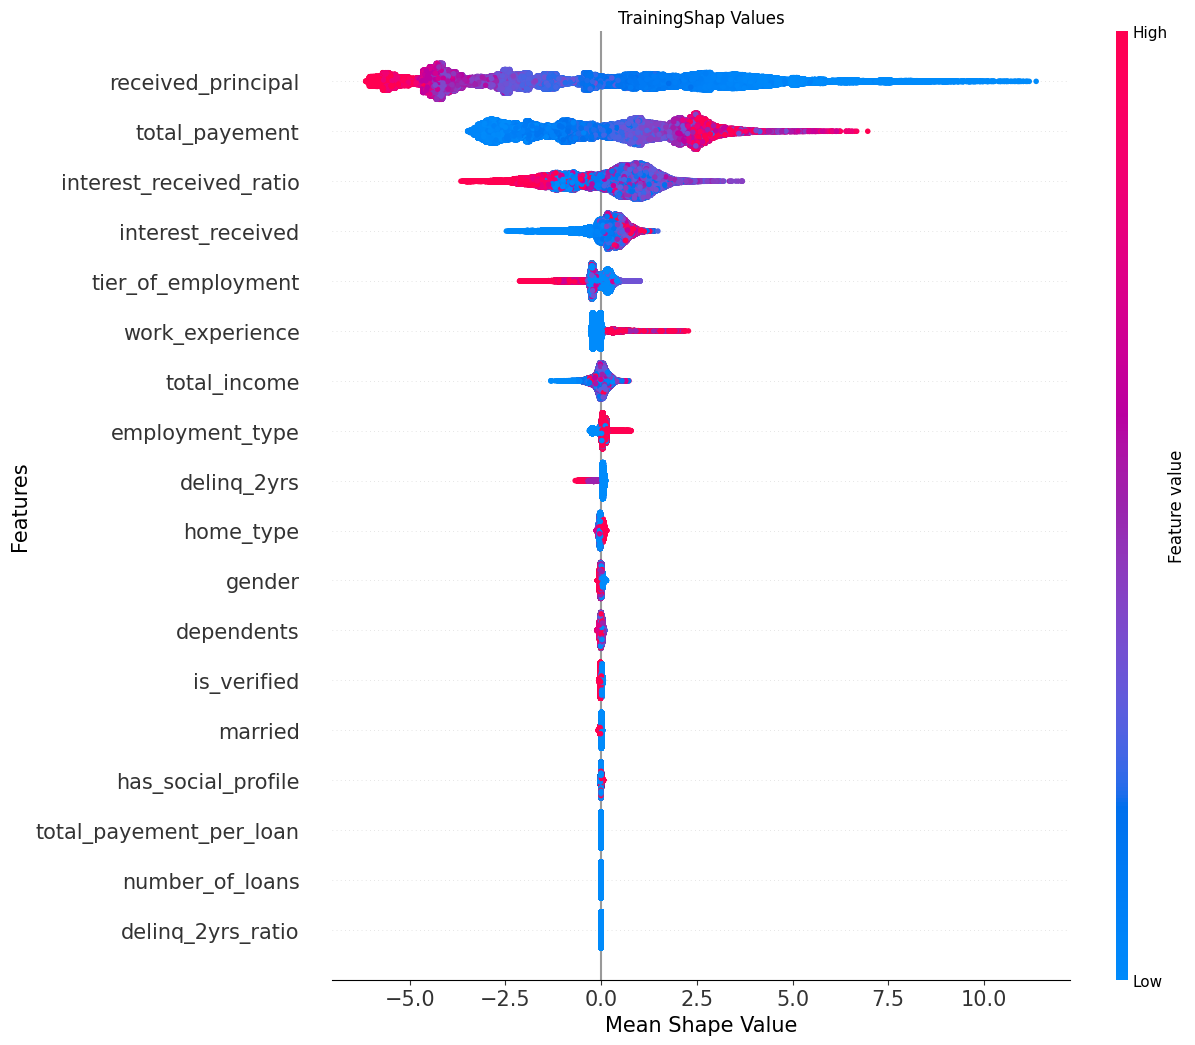

SHAP values shape for Validation data: (28750, 18)


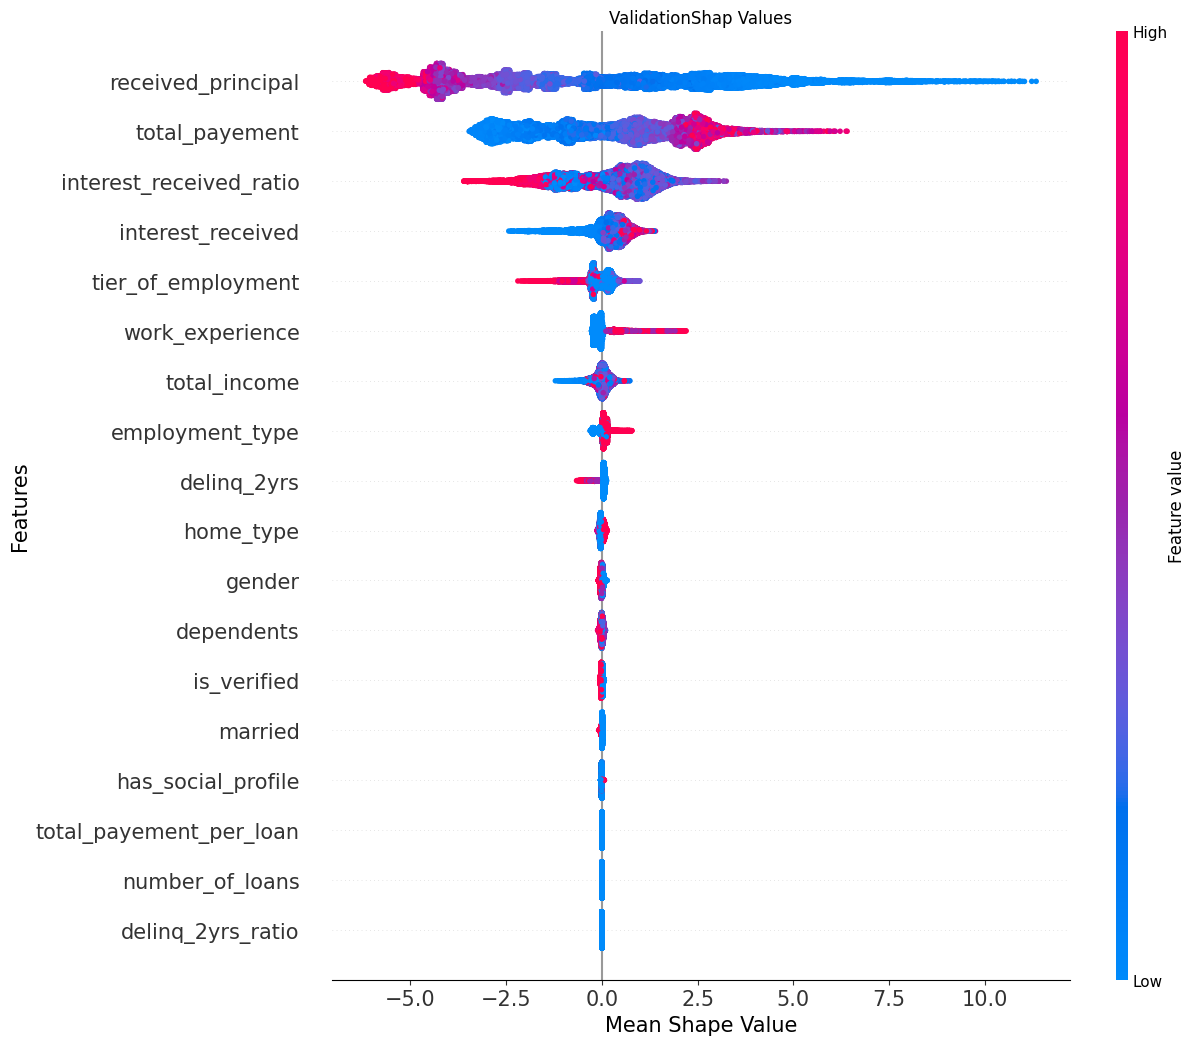

SHAP values shape for Hold Out data: (28727, 18)


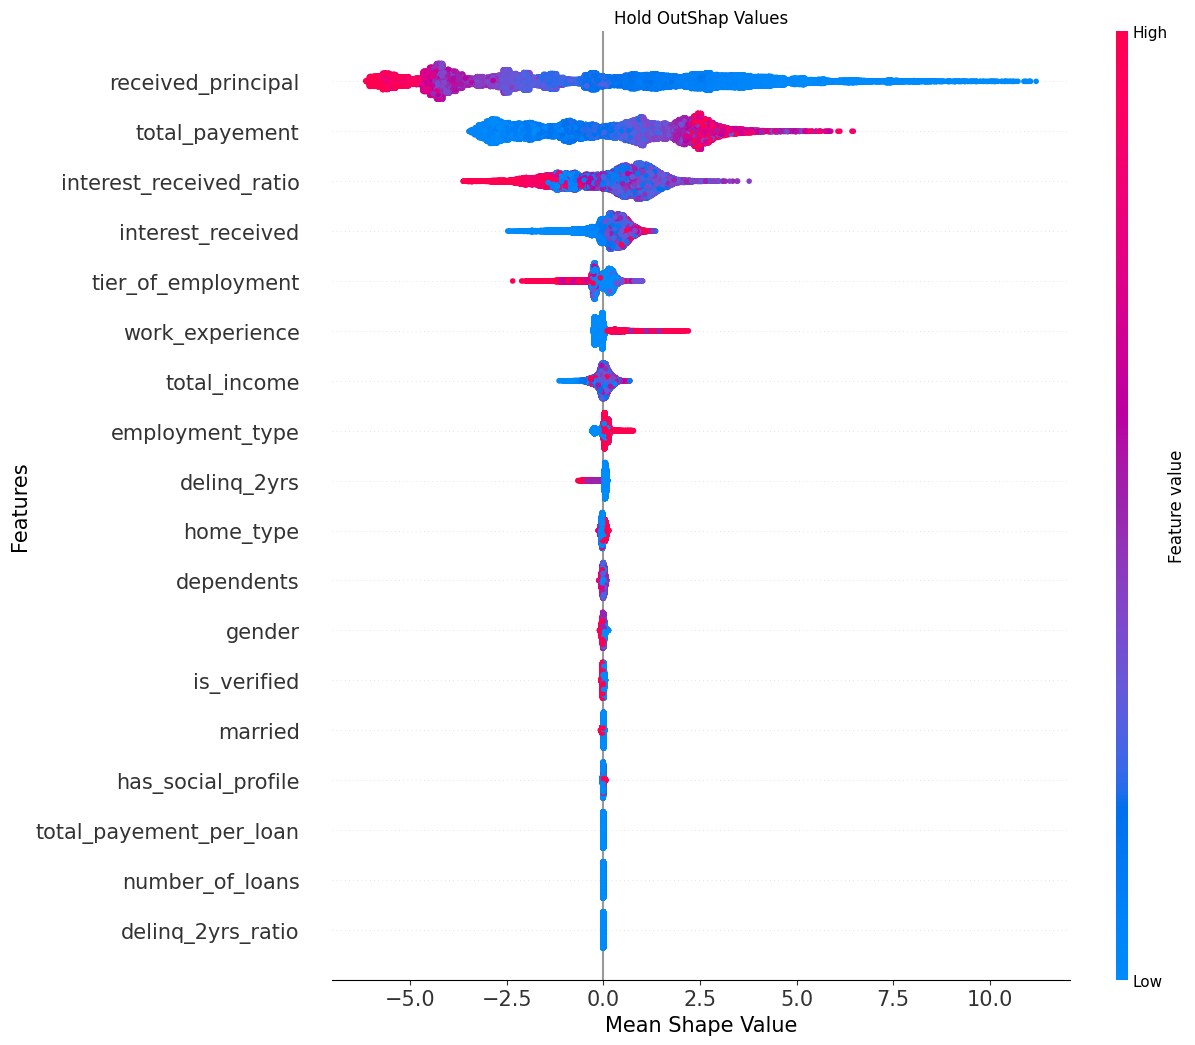

In [333]:
data_list = [train,val,hold_out]
data_type_list = ['Training', 'Validation', 'Hold Out']
shap_importance(clf, data_list, data_type_list)

Key Points
- Top features are consistent across Training, Validation, Hold Out (Higher the inconsistency, higher the chances the model is overfitting and will decay soon)

# Making Sense of Score
## Class Rate Curve

This Curve Tells 2 important things
1. Default rate across different score bucket for Train, Validation and Hold Out
2. User Distribution across different score bucket for Train, Validation and Hold Out

<br>
In Case User Distribution across different score bucket is very inconsistent in Train, Validation and Hold Out that means there is shift in domain of Out of Time Data

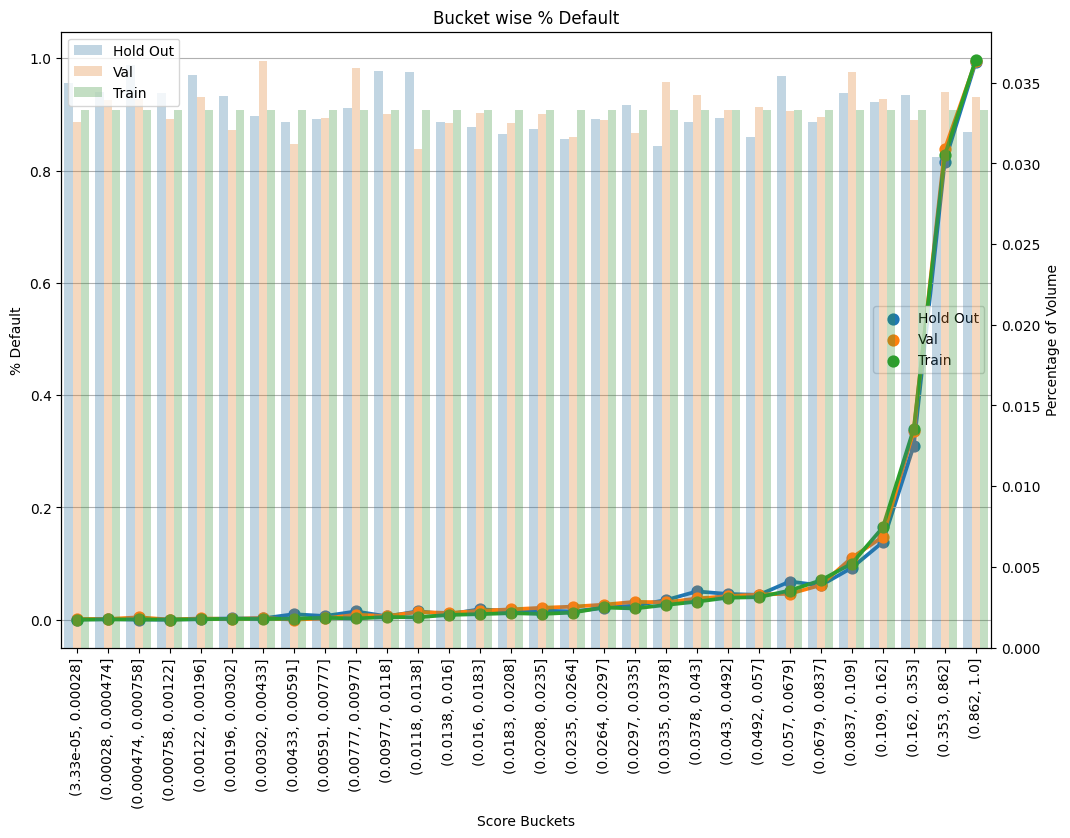

In [334]:
target_list = [train.label, val.label, hold_out.label]
pred_list = [pred_train, pred_val, pred_hold_out]
data_type_list = ['Train', 'Val', 'Hold Out']

class_rate(target_list, pred_list, data_type_list)

## Right Threshold

- Precision: Indicates the proportion of true positive predictions among all positive predictions. It measures the proportion of true positive predictions (correctly identified defaulters) among all positive predictions (all identified as defaulters)
- Recall: Indicates the proportion of true positives identified among all actual positives.
- F1 Score: Harmonic mean of precision and recall, providing a single metric that balances both.
- Specificity: Indicates the proportion of true negatives identified among all actual negatives.
- True Positives (TP): Number of correctly identified defaulters.
- False Positives (FP): Number of non-defaulters incorrectly identified as defaulters.
- True Negatives (TN): Number of correctly identified non-defaulters.
- False Negatives (FN): Number of defaulters incorrectly identified as non-defaulters.

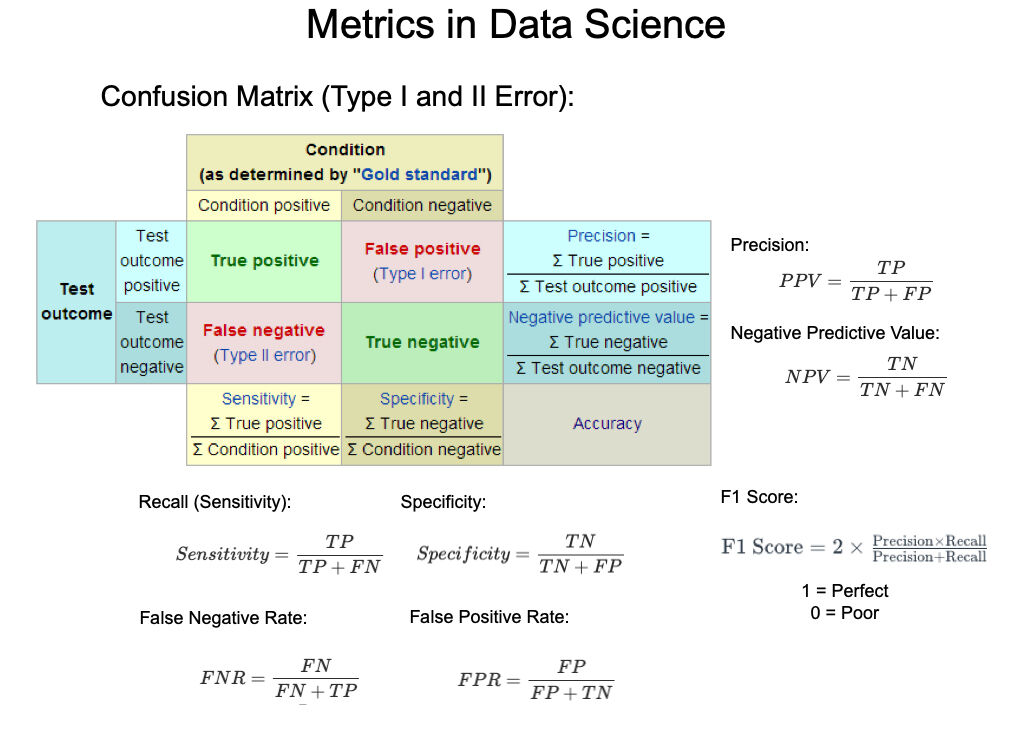

In [473]:
# Calculating cutoff score
desired_default_rate = 0.01
cutoff = cutoff_score(val.label, pred_val, desired_default_rate)
print(f"Desired cumulative default rate at {desired_default_rate*100}%, cutoff score (threshold): {round(cutoff,3)}")

Desired cumulative default rate at 1.0%, cutoff score (threshold): 0.034


In [474]:
pred = pd.DataFrame({"label":val.label, "score":pred_val}).sort_values(by = 'score').reset_index(drop = True)
pred['cummulative_defaulters'] = pred['label'].cumsum(axis = 0)
pred['cummulative_default'] = (pred['cummulative_defaulters']/pred.index).fillna(0) #Calculates the cumulative default rate by dividing the cumulative number of defaulters by the index (which represents the number of observations considered so far). fillna(0) ensures that any division by zero (which happens at the first index) is replaced with 0.
cutofff = pred[pred.cummulative_default<=0.01]['score'].max()#Filters the DataFrame to include only those rows where the cumulative default rate is less than or equal to the desired default rate.
print(cutofff)
pred

0.03364845173830415


,label,score,cummulative_defaulters,cummulative_default
0,0,0.000,0,0.000
1,0,0.000,0,0.000
2,0,0.000,0,0.000
3,0,0.000,0,0.000
4,0,0.000,0,0.000
...,...,...,...,...
28745,1,1.000,2805,0.098
28746,1,1.000,2806,0.098
28747,1,1.000,2807,0.098
28748,1,1.000,2808,0.098


A cutoff score is an established score used to filter out unqualified candidates on any particular test or assessment. A cut-off score is the lowest possible credit score an applicant can have and still qualify for a loan or other form of credit from a particular lending institution. 

This Cutoff score indicates that if you classify instances with a predicted probability above this threshold as the positive class (default), you should achieve an overall default rate of approximately 1% in the validation dataset.

The cutoff score is a threshold above which you classify instances as belonging to the positive class (e.g., a default or a positive prediction). In your case, the cutoff score of 0.042553230927538835 means that any instance with a predicted probability greater than this threshold would be classified as a positive (default).


For a lender, determining an appropriate cutoff score at a desired cumulative default rate is crucial for risk management and decision-making. Here's why this approach is useful:

1. Risk Assessment:
Objective: The lender needs to understand and control the risk of default associated with their loan portfolio.
Usage: By setting a cutoff score based on a desired default rate, the lender can identify which loan applications to approve or reject to maintain the risk within acceptable limits.
2. Maximizing Profitability:
Objective: The lender aims to maximize profitability by balancing the approval of high-risk loans (which may have higher interest rates) with the risk of defaults.
Usage: Setting a cutoff score helps in approving loans that are less likely to default, thus reducing potential losses from bad loans while still capturing profitable, lower-risk loans.
3. Optimizing Loan Approvals:
Objective: The lender wants to approve as many loans as possible without exceeding a certain risk threshold.
Usage: By determining a cutoff score that corresponds to a specific default rate, the lender can optimize the number of approved loans while controlling the risk of defaults.

Let's consider an example to illustrate how a lender might use the cutoff score:

- Loan Application Process: The lender receives a set of loan applications and uses a predictive model to assign a score to each application, indicating the likelihood of default.
- Desired Default Rate: The lender decides that they are willing to accept a cumulative default rate of up to 1% (0.01).
- Calculate Cutoff Score: Using the cutoff_score function, the lender calculates the cutoff score that corresponds to this 1% default rate.
- Decision Making:

    * Applications with scores below the cutoff are rejected to keep the overall default rate within the desired threshold.
    * Applications with scores above the cutoff are approved, balancing the lender’s risk and profitability.

**Evaluating the Cutoff Score**

To determine if this is a good cutoff score, you need to consider the following metrics:

- True Positive Rate (TPR) / Sensitivity / Recall: The proportion of actual positives that are correctly identified.
- False Positive Rate (FPR): The proportion of actual negatives that are incorrectly identified as positives.
- Precision: The proportion of positive predictions that are actually positive. It measures the proportion of true positive predictions (correctly identified defaulters) among all positive predictions (all identified as defaulters)
- Specificity: The proportion of actual negatives that are correctly identified.
- F1 Score: The harmonic mean of precision and recall.
- Default Rate: The proportion of defaults in the predicted positive class.
- Confusion Matrix: Provides counts of true negatives (TN), false positives (FP), false negatives (FN), and true positives (TP).

In [475]:
metrics = evaluate_cutoff(val['label'], pred_val, cutoff)

# Print metrics
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Precision: 0.2457
Recall: 0.9359
F1 Score: 0.3893
Specificity: 0.6889
Default Rate: 0.2457
Confusion Matrix: (17871, 8070, 180, 2629)
True Positives: 2629
False Positives: 8070
True Negatives: 17871
False Negatives: 180


- Precision (0.2457): This means that when the model predicts a default, it is correct 24.57% of the time. In other words, out of all positive predictions, only 24.01% are actual defaults. The precision is the ratio ``tp / (tp + fp)``. The precision is
    intuitively the ability of the classifier not to label as positive a sample that is negative. It measures the proportion of true positive predictions (correctly identified defaulters) among all positive predictions (all identified as defaulters).
- Recall (0.9359): This indicates that the model is able to identify 93.59% of all actual defaults. It has a high recall, meaning it captures most of the defaults.
- F1 Score (0.3892): The F1 score, which is the harmonic mean of precision and recall, is 0.3892. This indicates a balance between precision and recall, but the relatively low value suggests there is room for improvement.
- Specificity (0.6889): This means that the model correctly identifies 67.89% of the non-defaults. Specificity is lower than recall, indicating that the model is better at identifying defaults than non-defaults.
- Confusion Matrix: 
    
    * True Negatives (TN): 17871 | False Positives (FP): 8070 | False Negatives (FN): 180 | True Positives (TP): 2629

    * High Recall but Low Precision: The model is good at capturing actual defaults (high recall) but is not very precise in its predictions (low precision). This means that there are many false positives, which might be costly if misclassifications lead to unnecessary actions.
    
    * Trade-offs: Depending on the business context, a high recall might be desired (e.g., identifying as many defaults as possible) even if it comes with a lower precision. However, if false positives are very costly, you might need to find a balance by adjusting the cutoff.

In [476]:
# Applying the cutoff to make decisions
print(cutoff)
pred = pd.DataFrame({"label":val.label, "score":pred_val}).sort_values(by = 'score').reset_index(drop = True)
pred['decision'] = pred['score'].apply(lambda x: 'Reject' if x >= cutoff else 'Approve')
print(pred['decision'].value_counts())
print(pred['label'].value_counts())

# Calculate the number of approved loans that ended up defaulting
defaulted_approved_loans = pred[(pred['decision'] == 'Approve') & (pred['label'] == 1)].shape[0]

print(f"Number of approved loans that defaulted: {defaulted_approved_loans}")

0.03364845173830415
decision
Approve    18051
Reject     10699
Name: count, dtype: int64
label
0    25941
1     2809
Name: count, dtype: int64
Number of approved loans that defaulted: 180


In [477]:
# Calculating cutoff score
desired_default_rate = 0.03
cutoff = cutoff_score(val.label, pred_val, desired_default_rate)
print(f"Desired default rate at {desired_default_rate*100}%, cutoff score (threshold): {round(cutoff,3)}")

Desired default rate at 3.0%, cutoff score (threshold): 0.213


In [478]:
metrics = evaluate_cutoff(val['label'], pred_val, cutoff)

# Print metrics
for metric, value in metrics.items():
    print(f"{metric}: {value}")

Precision: 0.8049
Recall: 0.7198
F1 Score: 0.76
Specificity: 0.9811
Default Rate: 0.8049
Confusion Matrix: (25451, 490, 787, 2022)
True Positives: 2022
False Positives: 490
True Negatives: 25451
False Negatives: 787


In [479]:
# Applying the cutoff to make decisions
print(cutoff)
pred = pd.DataFrame({"label":val.label, "score":pred_val}).sort_values(by = 'score').reset_index(drop = True)
pred['decision'] = pred['score'].apply(lambda x: 'Reject' if x >= cutoff else 'Approve')
print(pred['decision'].value_counts())
print(pred['label'].value_counts())

# Calculate the number of approved loans that ended up defaulting
defaulted_approved_loans = pred[(pred['decision'] == 'Approve') & (pred['label'] == 1)].shape[0]

print(f"Number of approved loans that defaulted: {defaulted_approved_loans}")

0.21303917697134686
decision
Approve    26238
Reject      2512
Name: count, dtype: int64
label
0    25941
1     2809
Name: count, dtype: int64
Number of approved loans that defaulted: 787


**For Example**

You decide the cutoff score is 0.7. This means:

- People with scores 0.5 and 0.6 get loans.
- People with scores 0.7, 0.8, and 0.9 do not get loans.

In [480]:
# Adjust the decision threshold
cutoff = 0.5  # Adjust this value to find a balance between precision and recall
binary_predictions = (pred_val >= cutoff).astype(int)

pred = pd.DataFrame({"label":val.label, "score":pred_val}).sort_values(by = 'score').reset_index(drop = True)
pred['cummulative_defaulters'] = pred['label'].cumsum(axis = 0)
pred['cummulative_default'] = (pred['cummulative_defaulters']/pred.index).fillna(0)

print(f"Cutoff score at {cutoff*100}%, cumulative default rate equal to: {round(pred[pred['score']<=cutoff]['cummulative_default'].max()*100,3)}%")

# Evaluate metrics at the new cutoff
tn, fp, fn, tp = confusion_matrix(val['label'], binary_predictions).ravel()
precision = precision_score(val['label'], binary_predictions)
recall = recall_score(val['label'], binary_predictions)
f1 = f1_score(val['label'], binary_predictions)
specificity = tn / (tn + fp)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Confusion Matrix: {tn, fp, fn, tp}")

Cutoff score at 50.0%, cumulative default rate equal to: 4.447%
Precision: 0.9587813620071685
Recall: 0.5713777144891421
F1 Score: 0.7160383671648449
Specificity: 0.9973401179599861
Confusion Matrix: (25872, 69, 1204, 1605)


In [481]:
# Applying the cutoff to make decisions
print(cutoff)
pred = pd.DataFrame({"label":val.label, "score":pred_val}).sort_values(by = 'score').reset_index(drop = True)
pred['decision'] = pred['score'].apply(lambda x: 'Reject' if x >= cutoff else 'Approve')
print(pred['decision'].value_counts())
print(pred['label'].value_counts())

# Calculate the number of approved loans that ended up defaulting
defaulted_approved_loans = pred[(pred['decision'] == 'Approve') & (pred['label'] == 1)].shape[0]

print(f"Number of approved loans that defaulted: {defaulted_approved_loans}")

0.5
decision
Approve    27076
Reject      1674
Name: count, dtype: int64
label
0    25941
1     2809
Name: count, dtype: int64
Number of approved loans that defaulted: 1204


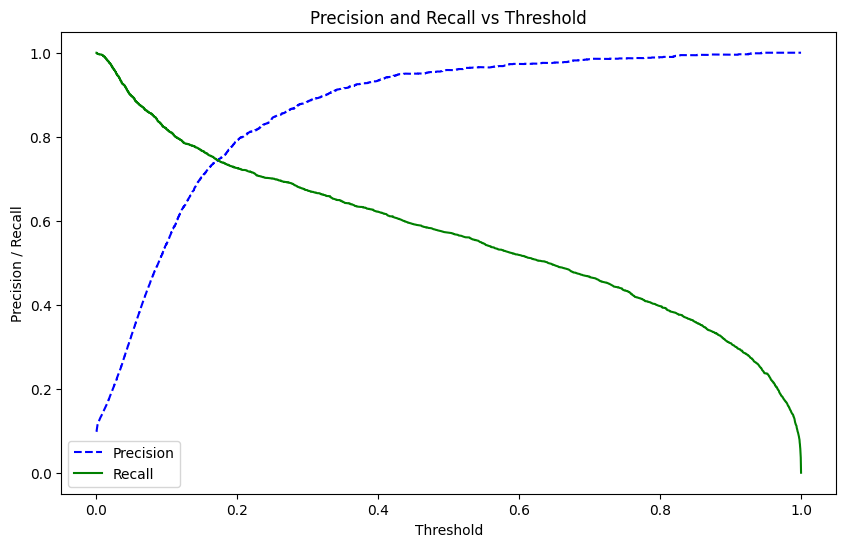

In [482]:
# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(val['label'], pred_val)
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision[:-1], 'b--', label='Precision')
plt.plot(thresholds, recall[:-1], 'g-', label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Precision / Recall')
plt.title('Precision and Recall vs Threshold')
plt.legend(loc='best')
plt.show()

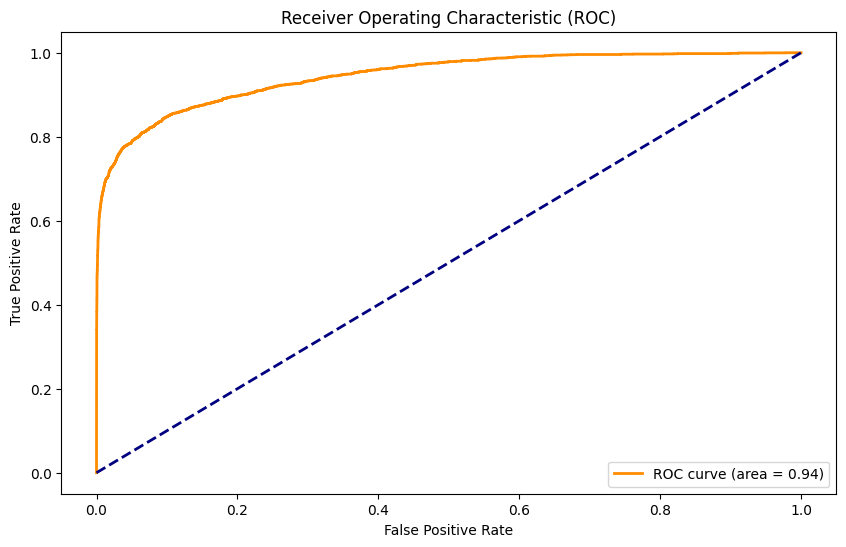

In [483]:
# ROC Curve
fpr, tpr, thresholds = roc_curve(val['label'], pred_val)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(10, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

**Business Goal?**
- High Precision: Focus on minimizing false positives (rejecting more risky applicants). It ensures that when the model predicts someone will default, it is very likely to be correct, minimizing the number of false positives (people who are wrongly identified as likely defaulters but would have repaid the loan).
- High Recall: Focus on identifying all potential defaulters (approving fewer loans but catching more defaulters).

In [484]:
# Find the optimal cutoff
metrics_df = find_optimal_cutoff(val['label'], pred_val)

# Print metrics for different cutoffs
print(metrics_df)

    Cutoff  Precision  Recall    F1  Specificity
0    0.000      0.098   1.000 0.178        0.000
1    0.010      0.147   0.992 0.257        0.378
2    0.020      0.187   0.973 0.313        0.541
3    0.030      0.231   0.945 0.372        0.660
4    0.040      0.281   0.920 0.430        0.744
..     ...        ...     ...   ...          ...
95   0.960      1.000   0.218 0.357        1.000
96   0.970      1.000   0.190 0.319        1.000
97   0.980      1.000   0.166 0.285        1.000
98   0.990      1.000   0.132 0.233        1.000
99   1.000      0.000   0.000 0.000        1.000

[100 rows x 5 columns]


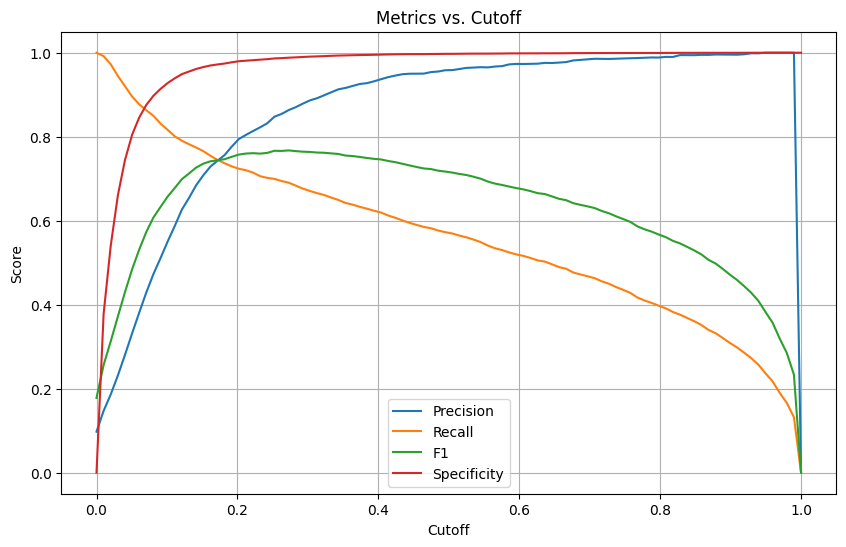

In [485]:
# Optionally, plot the metrics to visualize the trade-offs
metrics_df.plot(x='Cutoff', y=['Precision', 'Recall', 'F1', 'Specificity'], figsize=(10, 6))
plt.xlabel('Cutoff')
plt.ylabel('Score')
plt.title('Metrics vs. Cutoff')
plt.grid(True)
plt.show()

In [486]:
optimal_threshold = metrics_df.loc[metrics_df['Precision'].idxmax(), 'Cutoff']
print(f'Optimal Cutoff based on Precision Score: {optimal_threshold}')
# Apply the selected cutoff to make decisions

cutoff = optimal_threshold

Optimal Cutoff based on Precision Score: 0.9494949494949496


In [487]:
# Adjust the decision threshold
cutoff = 0.9494949494949496  # Adjust this value to find a balance between precision and recall
binary_predictions = (pred_val >= cutoff).astype(int)

pred = pd.DataFrame({"label":val.label, "score":pred_val}).sort_values(by = 'score').reset_index(drop = True)
pred['cummulative_defaulters'] = pred['label'].cumsum(axis = 0)
pred['cummulative_default'] = (pred['cummulative_defaulters']/pred.index).fillna(0)

print(f"Cutoff score at {round(cutoff*100,3)}%, cumulative default rate equal to: {round(pred[pred['score']<=cutoff]['cummulative_default'].max()*100,3)}%")

# Evaluate metrics at the new cutoff
tn, fp, fn, tp = confusion_matrix(val['label'], binary_predictions).ravel()
precision = precision_score(val['label'], binary_predictions)
recall = recall_score(val['label'], binary_predictions)
f1 = f1_score(val['label'], binary_predictions)
specificity = tn / (tn + fp)

print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")
print(f"Specificity: {specificity}")
print(f"Confusion Matrix: {tn, fp, fn, tp}")
print(f'True Positives: {tp}')
print(f'False Positives: {fp}')
print(f'True Negatives: {tn}')
print(f'False Negatives: {fn}')

Cutoff score at 94.949%, cumulative default rate equal to: 7.634%
Precision: 1.0
Recall: 0.2367390530437878
F1 Score: 0.3828439838802533
Specificity: 1.0
Confusion Matrix: (25941, 0, 2144, 665)
True Positives: 665
False Positives: 0
True Negatives: 25941
False Negatives: 2144


In [488]:
# Applying the cutoff to make decisions
print(cutoff)
pred = pd.DataFrame({"label":val.label, "score":pred_val}).sort_values(by = 'score').reset_index(drop = True)
pred['decision'] = pred['score'].apply(lambda x: 'Reject' if x >= cutoff else 'Approve')
print(pred['decision'].value_counts())
print(pred['label'].value_counts())

# Calculate the number of approved loans that ended up defaulting
defaulted_approved_loans = pred[(pred['decision'] == 'Approve') & (pred['label'] == 1)].shape[0]

print(f"Number of approved loans that defaulted: {defaulted_approved_loans}")

0.9494949494949496
decision
Approve    28085
Reject       665
Name: count, dtype: int64
label
0    25941
1     2809
Name: count, dtype: int64
Number of approved loans that defaulted: 2144
